<a href="https://colab.research.google.com/github/nafis10670/VGG16-transfer-learning-on-cats-and-dogs-dataset/blob/main/RIoT_Lab_Test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installing Kaggle

In [ ]:
!pip install kaggle

##Uploading the kaggle.json file to allow us to access Kaggle

In [16]:
from google.colab import files

uploaded = files.upload()

for _file in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=_file, length=len(uploaded[_file])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


##Download the cats-vs-dogs dataset from Kaggle

In [17]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


##Unzipping the dataset

In [ ]:
!unzip dogs-vs-cats.zip

##Unzipping the dataset

In [ ]:
!unzip test1.zip
!unzip train.zip

##Importing necessary libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

##Converting the dataset into a dataframe with proper labeling

In [21]:
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df["category"] = df["category"].astype(str)
print(df.head())
df.dtypes

        filename category
0   cat.8440.jpg        0
1   cat.2689.jpg        0
2   cat.1978.jpg        0
3  cat.10155.jpg        0
4   dog.8238.jpg        1


filename    object
category    object
dtype: object

##View a sample image from the dataset

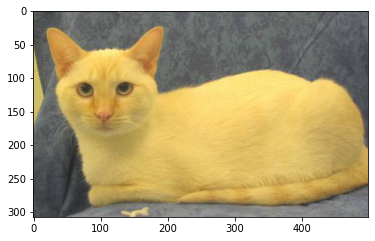

In [22]:
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
sample = random.choice(filenames)
image = load_img("../content/train/"+sample)
plt.imshow(image)

##Preparing the training and testing data

In [23]:
train, test = train_test_split(df, test_size=0.1)

#train

train = train.reset_index()
test = test.reset_index()


train_length = train.shape[0]
test_length = test.shape[0]

train

,index,filename,category
0,13452,cat.2564.jpg,0
1,16829,cat.5407.jpg,0
2,16014,cat.261.jpg,0
3,13485,dog.9612.jpg,1
4,6754,cat.11679.jpg,0
...,...,...,...
22495,21317,cat.7655.jpg,0
22496,23143,dog.11386.jpg,1
22497,20580,cat.5055.jpg,0
22498,14791,cat.7065.jpg,0


##Importing the VGG16 model and necessary libraries to build our model

In [24]:
from keras import layers
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, GlobalMaxPooling2D, Conv2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

##Building the model

In [25]:
image_size = 224
epochs = 5
batch_size = 16

#Getting the VGG16 model architecture
vgg16_base = VGG16(include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3))

#Freezing the base model
vgg16_base.trainable = False
# vgg16_base.summary()

#Getting the last layer of the base model
last_layer = vgg16_base.get_layer('block5_pool')
last_output = last_layer.output

#Using GMP instead of Flatten gives better accuracy
x = GlobalMaxPooling2D()(last_output)

x = Dense(512, activation='relu')(x)

#Dropout layer to reduce over-fitting
x = Dropout(0.5)(x)

#Output layer with sigmoid activation as this is a
#binary classification problem
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(vgg16_base.input, x)

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

model.summary()
len(model.trainable_weights) #View number of trainable weights


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

4

##Training Image Generator 

In [26]:
train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_gen.flow_from_dataframe(
    train, 
    "/content/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


##Testing Image Generator

In [27]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test, 
    "/content/train",  
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


##Fitting the model

In [28]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_length//batch_size,
    steps_per_epoch=train_length//batch_size)

Epoch 1/5
1406/1406 [==============================] - 321s 227ms/step - loss: 0.3077 - accuracy: 0.8611 - val_loss: 0.2241 - val_accuracy: 0.9002
Epoch 2/5
1406/1406 [==============================] - 317s 226ms/step - loss: 0.2574 - accuracy: 0.8895 - val_loss: 0.2065 - val_accuracy: 0.9115
Epoch 3/5
1406/1406 [==============================] - 318s 226ms/step - loss: 0.2468 - accuracy: 0.8923 - val_loss: 0.1668 - val_accuracy: 0.9267
Epoch 4/5
1406/1406 [==============================] - 317s 225ms/step - loss: 0.2405 - accuracy: 0.8937 - val_loss: 0.1651 - val_accuracy: 0.9299
Epoch 5/5
1406/1406 [==============================] - 317s 225ms/step - loss: 0.2333 - accuracy: 0.8989 - val_loss: 0.1635 - val_accuracy: 0.9295


##Plotting accuracy and loss graphs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


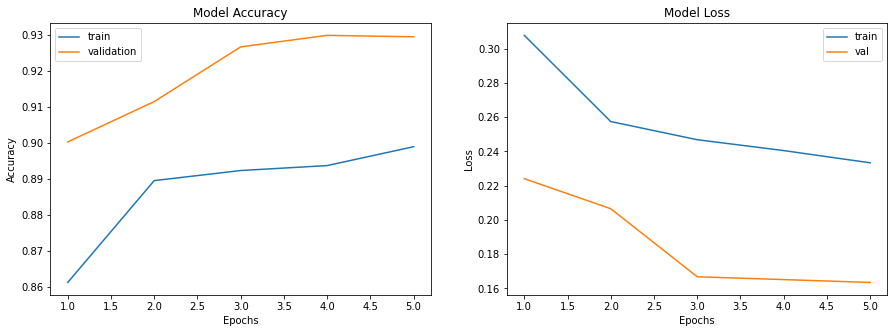

In [36]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'validation'], loc='best')

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'validation'], loc='best')
    plt.show()
    
plot_model_history(history)